In [7]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

PATH_DATASET = "/kaggle/input/icecube-neutrinos-in-deep-ice"

#### **Browse meta data**
##### **[train/test]_meta.parquet**

- **batch_id (int)**: the ID of the batch the event was placed into.
- **event_id (int)**: the event ID.
- **[first/last]_pulse_index (int)**: index of the first/last row in the features dataframe belonging to this event.
- **[azimuth/zenith] (float32)**: the [azimuth/zenith] angle in radians of the neutrino. A value between 0 and 2*pi for the azimuth and 0 and pi for zenith. The target columns. Not provided for the test set. The direction vector represented by zenith and azimuth points to where the neutrino came from.                 

In metadata files stored information about every event. For every event, we have batch_id, which determines, in which batch this event pulses are stored. Also, it has the first and last pulse index, related to this event. 

In [8]:
meta_test = pd.read_parquet(os.path.join(PATH_DATASET, "test_meta.parquet"))
print(f"length: {len(meta_test)}")
meta_test.head()

length: 3


batch_id  event_id  first_pulse_index  last_pulse_index
0       661      2092                  0               298
1       661      7344                299               334
2       661      9482                335               377

In [9]:
meta_train = pd.read_parquet(os.path.join(PATH_DATASET, "train_meta.parquet"))
print(f"length: {len(meta_train)}")
meta_train.head()

length: 131953924


batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117

uniue batch_ids in meta_train : 660


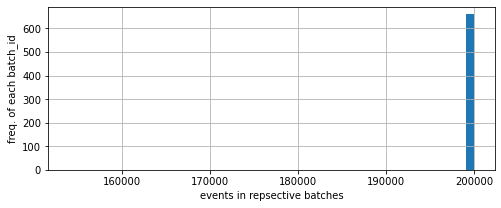

In [10]:
plt.figure(figsize=(8,3))
meta_train.groupby('batch_id').size().plot.hist(bins=50)
plt.xlabel('events in repsective batches'),plt.ylabel('freq. of each batch_id')
plt.grid()
print(f'uniue batch_ids in meta_train : {meta_train.batch_id.nunique()}')

Text(0.5, 0, 'time')

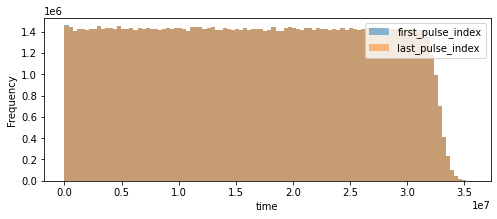

In [11]:
meta_train[['first_pulse_index','last_pulse_index']].plot.hist(bins=100,alpha=0.5,figsize=(8,3))
plt.xlabel('time')

#### **Delay between first and last pulse**

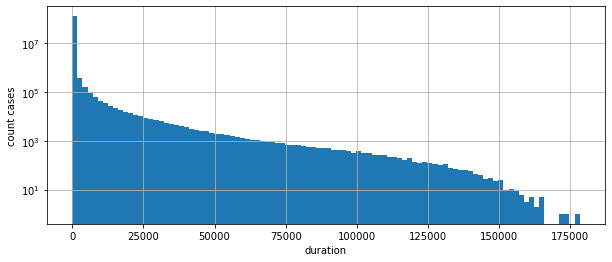

In [12]:
plt.figure(figsize=(10,4))
meta_train['delay_pulse_index'] = meta_train['last_pulse_index'] - meta_train['first_pulse_index']
_ = plt.hist(meta_train['delay_pulse_index'],bins=100,log=True)
plt.ylabel('count cases'), plt.xlabel('duration')
plt.grid()

#### **Azimuth and Zenith angle (solar directions)**
Finally, it has azimuth and zenith values. This value describes, where the neutrino came from. Azimuth is the angle of the direction of the sun measured clockwise north from the horizon. Zenith angle measured from the local zenith and the line of sight of the sun. In our dataset, these values are given in radians. Azimuth values are between 0 and  2∗pi
  and zenith values are between 0 and pi (because azimuth varies from 0° to 360° and zenith from 0° to 180°)

<img src='https://www.researchgate.net/publication/354755033/figure/fig2/AS:1070891857362948@1632331923300/Schematic-depicting-the-solar-zenith-angle-solar-altitude-angle-and-solar-azimuth-angle.ppm' width='500'/>

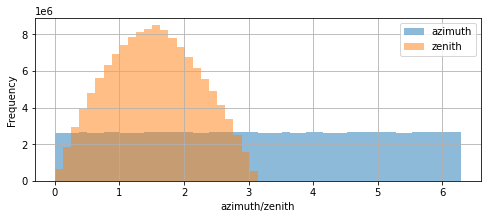

In [13]:
meta_train[["azimuth", "zenith"]].plot.hist(bins=50, alpha=0.5, figsize=(8, 3))
plt.xlabel('azimuth/zenith')
plt.grid()

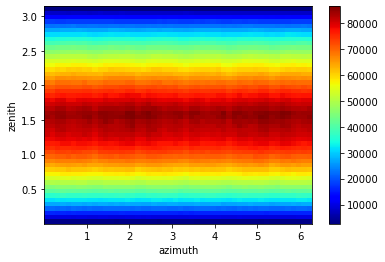

In [14]:
plt.hist2d(meta_train['azimuth'],meta_train['zenith'],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel('azimuth'),plt.ylabel('zenith')
plt.colorbar()

As we see, azimuth values are between 0 and  2∗pi
  and zenith values are between 0 and pi.

The distribution of azimuth values is uniform, which means, there are equal numbers of events with any azimuth angles. But the distribution of zenith values has a more normal-like distribution. It means, that most of the neutrinos, detected by IceCube, go perpendicularly to the strings of DOMs.

#### **Browse sensor geometry**
The x, y, and z positions for each of the 5160 IceCube sensors. The row index corresponds to the sensor_idx feature of pulses. The x, y, and z coordinates are in units of meters, with the origin at the center of the IceCube detector. The coordinate system is right-handed, and the z-axis points upwards when standing at the South Pole.

In [15]:
sensor_geometry = pd.read_csv(os.path.join(PATH_DATASET,"sensor_geometry.csv"))
print(f"length:{len(sensor_geometry)}")
sensor_geometry.head()

length:5160


sensor_id       x       y       z
0          0 -256.14 -521.08  496.03
1          1 -256.14 -521.08  479.01
2          2 -256.14 -521.08  461.99
3          3 -256.14 -521.08  444.97
4          4 -256.14 -521.08  427.95

In [16]:
sensor_geometry['z'].max(), sensor_geometry['z'].min()

(524.56, -512.82)

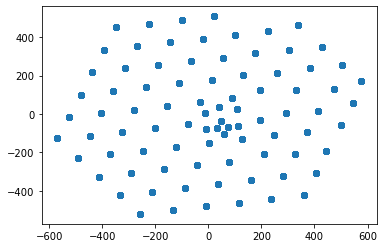

In [17]:
plt.scatter(sensor_geometry.x, sensor_geometry.y)

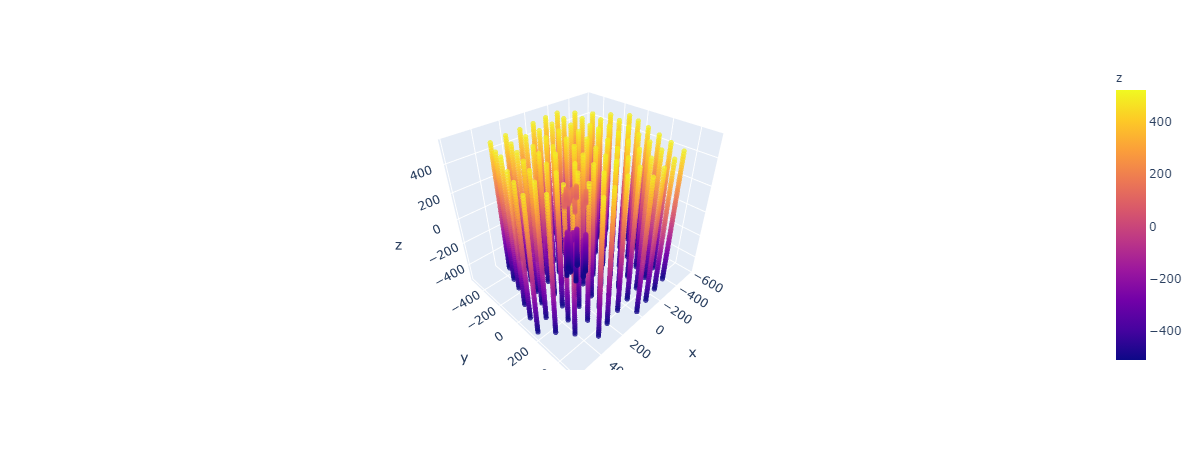

In [18]:
import plotly.express as px
fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', color="z", opacity=0.75)
fig.update_traces(marker_size=3)
fig.show()

There are strings, where sensors go one by one by the z-axis. Interestingly, there are 8 strings of sensors, which looks different. They have lower distances between sensors but are located at some particular parts of the z-axis. As we see, the coordinates are normalized, and in reality position of these sensors is between 1450-2450 meters by the z-axis.

Also, we can check out ranges, where these sensors are located

In [19]:
print(f'X axis: top {sensor_geometry["x"].max()} bottom {sensor_geometry["x"].min()}')
print(f'Y axis: top {sensor_geometry["y"].max()} bottom {sensor_geometry["y"].min()}')
print(f'Z axis: top {sensor_geometry["z"].max()} bottom {sensor_geometry["z"].min()}')

X axis: top 576.37 bottom -570.9
Y axis: top 509.5 bottom -521.08
Z axis: top 524.56 bottom -512.82


In [20]:
from pathlib import Path
def count_batches(path):
    counter = 0
    for item in path.glob('*'):
        if item.is_file():
            counter += 1
    return counter

print(f'Batches in train folder: {count_batches(Path(os.path.join(PATH_DATASET,"train")))}')
print(f'Batches in test folder: {count_batches(Path(os.path.join(PATH_DATASET,"test")))}')

Batches in train folder: 660
Batches in test folder: 1


In [21]:
test = pd.read_parquet(os.path.join(PATH_DATASET, "test/batch_661.parquet"))
print(f"length: {len(test)}")
print(f"Shape: {test.shape}")
print(f"events: {len(test.index.unique())}")
test.head()

length: 378
Shape: (378, 4)
events: 3


sensor_id  time  charge  auxiliary
event_id                                    
2092           4066  6170   1.275       True
2092           3512  6374   0.975       True
2092            897  6378   1.475       True
2092           2060  6590   0.925       True
2092           3072  6625   1.075       True

In [22]:
train = pd.read_parquet(os.path.join(PATH_DATASET, "train/batch_1.parquet"))
print(f"Shape: {train.shape}")
print(f"events: {len(train.index.unique())}")
train.head()

Shape: (32792416, 4)
events: 200000


sensor_id  time  charge  auxiliary
event_id                                    
24             3918  5928   1.325       True
24             4157  6115   1.175       True
24             3520  6492   0.925       True
24             5041  6665   0.225       True
24             2948  8054   1.575       True

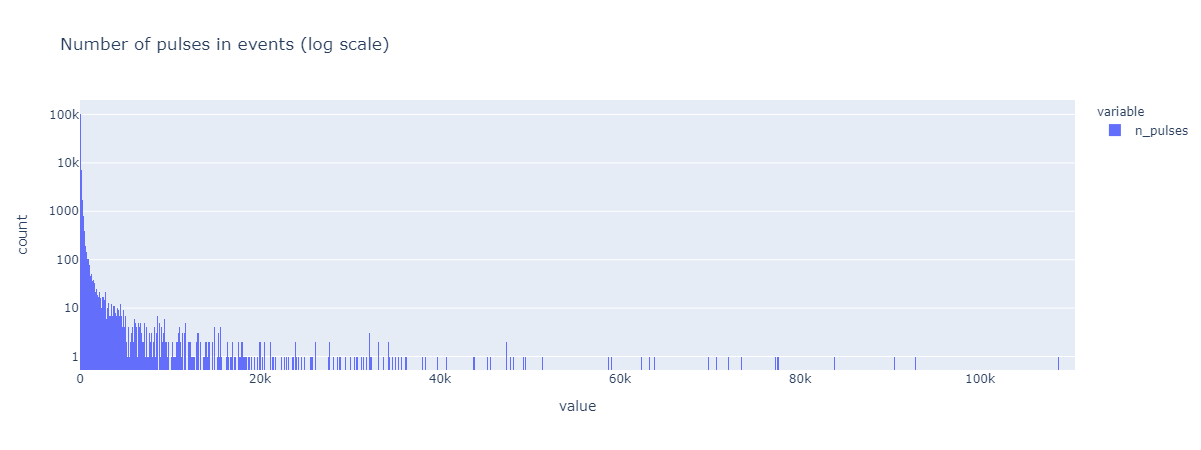

In [23]:
pulses_in_batch = pd.DataFrame(train.groupby('event_id').size(), columns=["n_pulses"])
fig = px.histogram(
    pulses_in_batch,
    log_y=True,
    title="Number of pulses in events (log scale)"
)
fig.show()

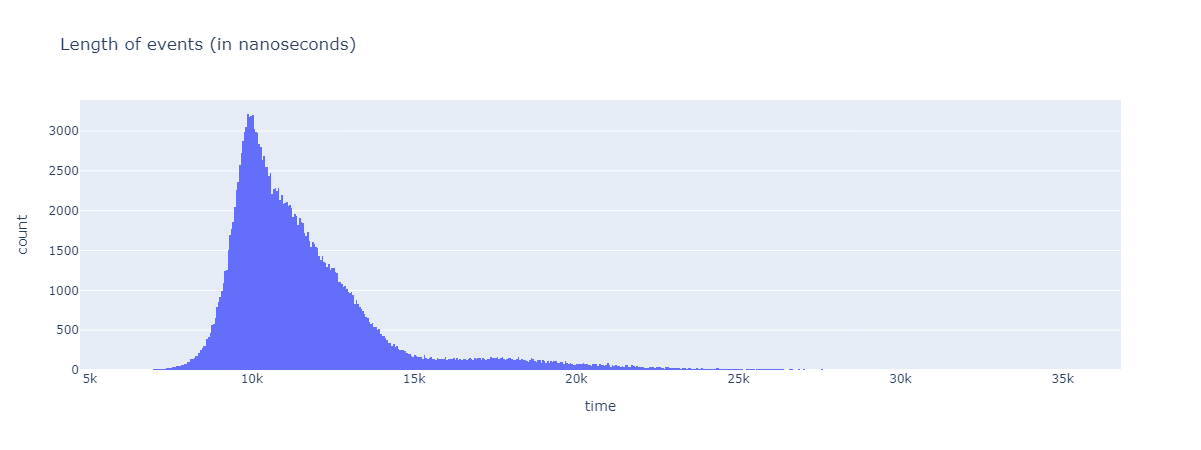

In [24]:
event_time_lengthes = pd.DataFrame(train.groupby('event_id')['time'].agg(np.ptp))
fig = px.histogram(
    event_time_lengthes,
    x="time",
    title="Length of events (in nanoseconds)"
)
fig.show()

As seen from hist, most of the events last for around 10,000 nanoseconds (0.00001 seconds). This graph looks different from the previous one, so it looks like there is no correlation between the length of the event and the number of pulses in the event. Let's check that out

In [25]:
event_time_lengthes.corrwith(pulses_in_batch["n_pulses"], axis=0)

time    0.265089
dtype: float64

Yes, there is not a big correlation between the number of pulses and the length of the event.

### **Breakdown of an event**
Let's analyze some events to understand better, what these events look like.

First, we have to take some event id for our analysis

In [26]:
train

sensor_id   time  charge  auxiliary
event_id                                     
24             3918   5928   1.325       True
24             4157   6115   1.175       True
24             3520   6492   0.925       True
24             5041   6665   0.225       True
24             2948   8054   1.575       True
...             ...    ...     ...        ...
3266196        1961  17617   0.975       True
3266196          36  17705   0.625       True
3266196         356  18192   0.725       True
3266196        2826  18609   0.575       True
3266196        5013  18741   1.375       True

[32792416 rows x 4 columns]

In [27]:
train = train.reset_index()

In [28]:
import random
random.seed(42)
analyze_event_id = random.choice(list(train['event_id']))
meta_of_event = meta_train[meta_train["event_id"] == analyze_event_id]
meta_of_event

batch_id  event_id  first_pulse_index  last_pulse_index   azimuth  \
133695         1   2180130           21440246          21456821  0.819718   

          zenith  delay_pulse_index  
133695  1.208597              16575

In [29]:
event_pulses = train[train['event_id'] == analyze_event_id]
print(f'Total number of pulses for this particular event: {len(event_pulses)}')

Total number of pulses for this particular event: 16576


There are 16576 pulses in this event. It could be worse, like 100,000 pulses😅

Now we can visualize the pulses and path of the neutrino particle

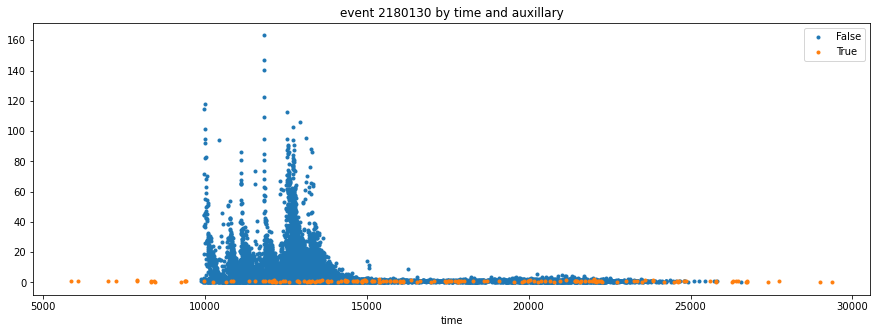

In [30]:
event_pulses.set_index('time').groupby('auxiliary')['charge'] \
          .plot(style='.',figsize=(15,5),title=f'event {analyze_event_id} by time and auxillary')
plt.legend()

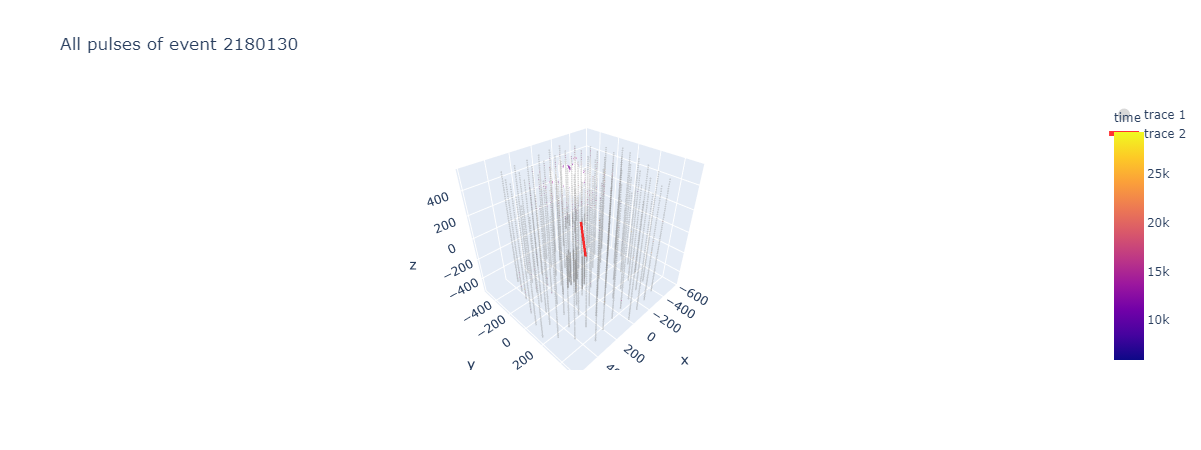

In [31]:
import plotly.graph_objects as go
import math

x_of_pulses = []
y_of_pulses = []
z_of_pulses = []
charges_of_pulses = []
times_of_pulses = []

for idx, row in event_pulses.iterrows():
    curr_sensor_data = sensor_geometry[sensor_geometry["sensor_id"] == row["sensor_id"]]
    curr_x, curr_y, curr_z = curr_sensor_data["x"].values[0], curr_sensor_data["y"].values[0], curr_sensor_data["z"].values[0]
    x_of_pulses.append(curr_x)
    y_of_pulses.append(curr_y)
    z_of_pulses.append(curr_z)
    charges_of_pulses.append(row["charge"])
    times_of_pulses.append(row["time"])

df = pd.DataFrame({"x": x_of_pulses, "y": y_of_pulses, "z": z_of_pulses, "charge": charges_of_pulses, "time": times_of_pulses})

fig = px.scatter_3d(df, x='x', y='y', z='z', opacity=0.75, color='time', size='charge', title=f"All pulses of event {analyze_event_id}")
fig.add_trace(
    go.Scatter3d(x=sensor_geometry["x"], y=sensor_geometry["y"], z=sensor_geometry["z"], mode='markers', opacity=0.3, marker=dict(size=1, color="gray"))
)
# draw direction vector using angles
azimuth, zenith = meta_of_event["azimuth"].values[0], meta_of_event["zenith"].values[0]
true_x = math.cos(azimuth) * math.sin(zenith)
true_y = math.sin(azimuth) * math.sin(zenith)
true_z = math.cos(zenith)
fig.add_trace(
    go.Scatter3d(
        x=[-true_x * 500, true_x * 500], y=[-true_y * 500, true_y * 500], z=[-true_z * 500, true_z * 500],
        opacity=0.8, mode='lines', line=dict(color='red', width=5)
    )
)

fig.show()

Number of not auxiliary pulses: 16410


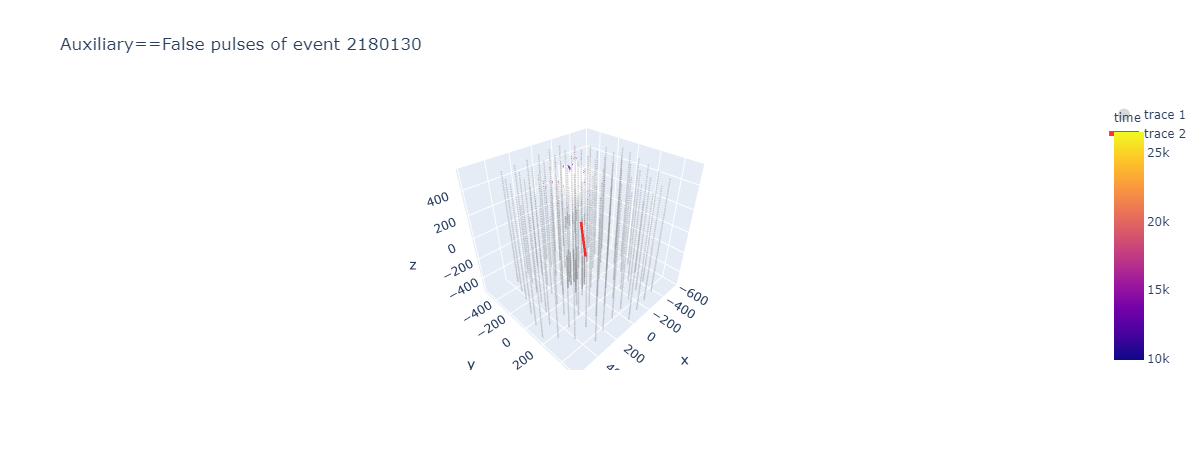

In [32]:
x_of_pulses = []
y_of_pulses = []
z_of_pulses = []
charges_of_pulses = []
times_of_pulses = []

no_auxiliary_event_pulses = event_pulses[event_pulses["auxiliary"] == False]
print(f"Number of not auxiliary pulses: {no_auxiliary_event_pulses.shape[0]}")

for idx, row in no_auxiliary_event_pulses.iterrows():
    curr_sensor_data = sensor_geometry[sensor_geometry["sensor_id"] == row["sensor_id"]]
    curr_x, curr_y, curr_z = curr_sensor_data["x"].values[0], curr_sensor_data["y"].values[0], curr_sensor_data["z"].values[0]
    x_of_pulses.append(curr_x)
    y_of_pulses.append(curr_y)
    z_of_pulses.append(curr_z)
    charges_of_pulses.append(row["charge"])
    times_of_pulses.append(row["time"])

df = pd.DataFrame({"x": x_of_pulses, "y": y_of_pulses, "z": z_of_pulses, "charge": charges_of_pulses, "time": times_of_pulses})

fig = px.scatter_3d(df, x='x', y='y', z='z', opacity=0.75, color='time', size='charge', title=f"Auxiliary==False pulses of event {analyze_event_id}")
fig.add_trace(
    go.Scatter3d(x=sensor_geometry["x"], y=sensor_geometry["y"], z=sensor_geometry["z"], mode='markers', opacity=0.3, marker=dict(size=1, color="gray"))
)

azimuth, zenith = meta_of_event["azimuth"].values[0], meta_of_event["zenith"].values[0]
true_x = math.cos(azimuth) * math.sin(zenith)
true_y = math.sin(azimuth) * math.sin(zenith)
true_z = math.cos(zenith)
fig.add_trace(
    go.Scatter3d(
        x=[-true_x * 500, true_x * 500], y=[-true_y * 500, true_y * 500], z=[-true_z * 500, true_z * 500],
        opacity=0.8, mode='lines', line=dict(color='red', width=5)
    )
)

fig.show()

So, there are only 166 not auxiliary pulses from 16576 pulses in total in this event. Also, it seems like the path of neutrino does not go through sensors, which detected pulse. So, now this task looks harder😉

#### That concludes our EDA notebook for ICECUBE Neutrino prediction challenge....              
##### Next can vist other notebooks(containing model building and training):     
1. Graphnet (DynEdge) model solution
2. Custom GNN model